In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
import numpy as np
import pandas as pd

from os.path import join

import seaborn as sns
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

%matplotlib inline

In [3]:
## Load the State and Trait scores
eCON = '/data/bswift-1/Pessoa_Lab/eCON'
scores = pd.read_excel(join(eCON,'STAIscores/scores.xlsx'))
scores.rename(columns={'SCORING':'TRAIT'},inplace=True)
scores.drop(columns=['PAIR SCORE'],inplace=True)
scores['SubID'] = scores['SubID'].apply(lambda name: ''.join(name.strip().split("_")))

In [13]:
# ROIs to be included in the RBA
rois = 'vmPFC PCC1 PCC2 rPAG lPAG rvAI rdAI lvAI ldAI rPI lPI rBNST lBNST ACC\
        Amygdala_BLBM_La_R Amygdala_CeME_R Amygdala_BLBM_La_L Amygdala_CeME_L\
        rCa lCa rPa lPa rVS lVS'.split()

## List of ROIs to included in RBA

In [14]:
for i,roi in enumerate(rois):
    print(i+1,roi)

1 vmPFC
2 PCC1
3 PCC2
4 rPAG
5 lPAG
6 rvAI
7 rdAI
8 lvAI
9 ldAI
10 rPI
11 lPI
12 rBNST
13 lBNST
14 ACC
15 Amygdala_BLBM_La_R
16 Amygdala_CeME_R
17 Amygdala_BLBM_La_L
18 Amygdala_CeME_L
19 rCa
20 lCa
21 rPa
22 lPa
23 rVS
24 lVS


In [15]:
# Load the data that contains shock betas for all participants
#beta_df = pd.read_csv('Individual_betas_from_ROI_analysis_S.csv')
beta_df = pd.read_csv('Individual_betas_from_ROI_analysis_S_buttonPress.csv')

In [16]:
# Get only the shock betas for the rois mentioned above from beta_df and save it as a new df (all_roi_df)
all_rois_df = beta_df[beta_df['ROI'].isin(rois)][['Pair','Subject','Group','ROI','beta']]

In [17]:
# Pivot the table such that shock betas for every roi are put in separate columns
all_rois_df = all_rois_df.groupby(['Pair','Subject','Group','ROI'])['beta'].mean().unstack()
# Reset the columns because groupby create the creates multiple index columns
all_rois_df.reset_index(inplace=True)

In [18]:
# Extract the shock beta values from both goups, and subtract one from the other (uncontrol - control)
all_rois_pair_df = all_rois_df[all_rois_df['Group']=='uncontrol'][rois].values - all_rois_df[all_rois_df['Group']=='control'][rois].values
all_rois_pair_df = pd.DataFrame(all_rois_pair_df,columns=rois, index=all_rois_df.Pair.unique())
all_rois_pair_df.index.name = 'Pair'

In [19]:
all_rois_pair_df.reset_index(inplace = True)
all_rois_pair_df.head()

,Pair,vmPFC,PCC1,PCC2,rPAG,lPAG,rvAI,rdAI,lvAI,ldAI,...,Amygdala_BLBM_La_R,Amygdala_CeME_R,Amygdala_BLBM_La_L,Amygdala_CeME_L,rCa,lCa,rPa,lPa,rVS,lVS
0,P00,-0.054422,0.510746,0.373305,0.742407,-0.094870,0.217674,0.718224,-0.200550,0.307470,...,0.130619,0.231618,-0.083950,0.182758,0.078734,-0.061356,0.345429,0.025556,0.229500,0.267240
1,P01,-0.314688,-0.314805,-0.340549,0.195783,0.604223,0.255941,-0.079674,-0.193876,1.114953,...,0.217202,-0.123463,0.872065,0.091433,0.037642,0.074169,0.002690,0.309495,0.406163,0.772699
2,P02,-0.244115,-0.262159,-0.191688,-0.822900,-0.201661,-0.008536,0.291348,0.455112,-0.009914,...,0.526144,-2.019130,-0.622731,0.517025,0.018105,0.330122,0.200926,0.179117,0.536354,0.411100
3,P03,-0.236480,-0.234531,0.154024,-0.558640,0.071113,-0.336705,0.027717,0.906893,0.663435,...,-0.146609,-0.845896,0.077962,-1.145497,-0.058214,0.180903,0.044822,0.134032,-0.146908,-0.049464
4,P04,-0.531118,0.466587,-0.364676,0.685925,-0.406346,-0.273708,0.317377,-0.245136,0.458202,...,0.129951,-0.159148,-0.114695,0.198329,0.231403,0.487123,0.177450,0.010834,0.622764,0.220425


In [20]:
new_score_df = pd.DataFrame()
for pair in all_rois_df.Pair.unique():
    con = all_rois_df[(all_rois_df['Pair']==pair) & (all_rois_df['Group'] == 'control')]['Subject'].values[0]
    uncon = all_rois_df[(all_rois_df['Pair']==pair) & (all_rois_df['Group'] == 'uncontrol')]['Subject'].values[0]
    
    
    conTrait = scores[scores['SubID'] == con]['TRAIT'].values[0]
    unconTrait = scores[scores['SubID'] == uncon]['TRAIT'].values[0]
    
    conState = scores[scores['SubID'] == con]['STATE'].values[0]
    unconState = scores[scores['SubID'] == uncon]['STATE'].values[0]
    
    tmp_df = pd.DataFrame([pair,uncon,con,
                           unconTrait,conTrait,unconTrait-conTrait,np.mean([unconTrait,conTrait]),
                           unconState,conState,unconState-conState,np.mean([unconState,conState])],
                          index=['Pair',('SubID','uncontrol'),('SubID','control'),
                                  ('TRAIT','uncontrol'),('TRAIT','control'),('TRAIT','uncon-con'),('TRAIT','mean'),
                                  ('STATE','uncontrol'),('STATE','control'),('STATE','uncon-con'),('STATE','mean')]).T
    
    new_score_df = pd.concat([new_score_df,tmp_df],axis=0)
    
new_score_df.set_index('Pair',inplace=True)

In [21]:
# drop unimportant columns from the STAI scores df (new_score_Df)
new_score_df = new_score_df[[('TRAIT','uncon-con'),('TRAIT','mean'),('STATE','uncon-con'),('STATE','mean')]]

In [22]:
# Convert the numerical columns of new_score_df to float
for col in new_score_df.columns:
    new_score_df[col] = new_score_df[col].astype(float)

In [23]:
new_score_df.head()

,"(TRAIT, uncon-con)","(TRAIT, mean)","(STATE, uncon-con)","(STATE, mean)"
Pair,,,,
P00,0.0,27.0,-2.0,23.0
P01,9.0,31.5,4.0,28.0
P02,1.0,36.5,3.0,27.5
P03,3.0,22.5,-1.0,20.5
P04,0.0,33.0,6.0,29.0


In [24]:
# Reformat the tupled column names for (TRAIT, uncon-con) (TRAIT, mean) (STATE, uncon-con) (STATE, mean)
col_to_drop = []
for col in new_score_df.columns:
    if type(col) is tuple:
        
        col_to_drop.append(col)
        
        STAI, kind = col
        
        if '-' in kind:
            kind = 'diff'
            
        new_score_df[''.join([STAI,kind])] = new_score_df[col]
        
new_score_df.drop(columns=col_to_drop,inplace=True)

In [25]:
new_score_df.head()

,TRAITdiff,TRAITmean,STATEdiff,STATEmean
Pair,,,,
P00,0.0,27.0,-2.0,23.0
P01,9.0,31.5,4.0,28.0
P02,1.0,36.5,3.0,27.5
P03,3.0,22.5,-1.0,20.5
P04,0.0,33.0,6.0,29.0


In [26]:
# Standardize the four STAI scores
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
new_score_df_norm = pd.DataFrame(ss.fit_transform(new_score_df),
                                 columns=new_score_df.columns,
                                 index=new_score_df.index)

In [27]:
# Melt the allall_rois_pair_df such that all shock beta values are put one column, and every beta is marked by the roi which it belongs to by another column 'ROI' nex to it
all_rois_pair_df_melted = all_rois_pair_df.melt(id_vars='Pair',var_name='ROI',value_name='Y')
all_rois_pair_df_melted.set_index('Pair',inplace=True)
all_rois_pair_df_melted.head()

,ROI,Y
Pair,,
P00,vmPFC,-0.054422
P01,vmPFC,-0.314688
P02,vmPFC,-0.244115
P03,vmPFC,-0.236480
P04,vmPFC,-0.531118


In [32]:
# Join (on index 'Pair') the STAI score (new_score_df) and the roi shock beta (all_rois_pair_df_melted) dataframes
full_df = all_rois_pair_df_melted.join(new_score_df_norm)
full_df.reset_index(inplace=True)
full_df['Subj'] = full_df['Pair']
full_df.drop(columns = 'Pair',inplace=True)
col_order = ['Subj','ROI','Y','TRAITmean','TRAITdiff','STATEmean','STATEdiff']

In [33]:
print(full_df.head())
print(full_df.tail())

     ROI         Y  TRAITdiff  TRAITmean  STATEdiff  STATEmean Subj
0  vmPFC -0.054422  -0.040647  -1.003049  -0.181211  -1.230659  P00
1   PCC1  0.510746  -0.040647  -1.003049  -0.181211  -1.230659  P00
2   PCC2  0.373305  -0.040647  -1.003049  -0.181211  -1.230659  P00
3   rPAG  0.742407  -0.040647  -1.003049  -0.181211  -1.230659  P00
4   lPAG -0.094870  -0.040647  -1.003049  -0.181211  -1.230659  P00
      ROI         Y  TRAITdiff  TRAITmean  STATEdiff  STATEmean Subj
1459  lCa -0.175988  -1.103272   0.572285  -1.177055   0.830403  P62
1460  rPa  0.125831  -1.103272   0.572285  -1.177055   0.830403  P62
1461  lPa  0.216568  -1.103272   0.572285  -1.177055   0.830403  P62
1462  rVS -0.012240  -1.103272   0.572285  -1.177055   0.830403  P62
1463  lVS -0.263019  -1.103272   0.572285  -1.177055   0.830403  P62


In [34]:
full_df[col_order].to_csv('uncon_v_con_shock_MR_ROI24_with_covariates/uncon_v_con_shock_MR_ROI24_with_covariates2.txt',sep='\t',float_format='%.4f',index=False)

In [35]:
full_df[full_df['ROI']=='rBNST'][col_order].drop(columns='ROI').to_csv('uncon_v_con_rBNST_with_covariates/uncon_v_con_shock_MR_rBNST_with_covariates2.txt',sep='\t',float_format='%.4f',index=False)

# Distribution of Y (shock beta contrast [uncon-con])

Text(0.75, 150, 'Skeweness=0.345')

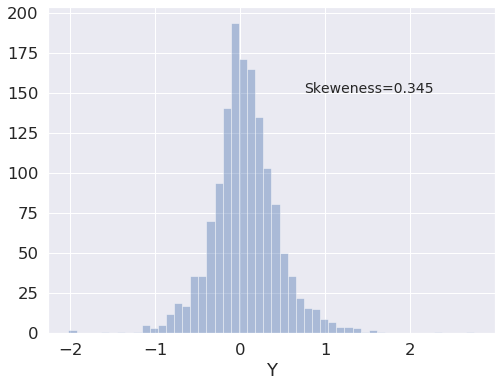

In [36]:
plt.figure(figsize = (8,6))
sns.distplot(full_df.Y,kde=False)
plt.text(x=0.75,y=150, s='Skeweness=%.3f' %(full_df.Y.skew()),fontdict={'size':14})

There is minor skewness but there are also a few outliers. Hence use student-t distribution for Y in RBA.